# Machine learning for Transformer Health Index Analysis

**Author:** Petar Sarajcev, PhD (petar.sarajcev@fesb.hr)

University of Split, FESB, Department of Power Engineering, R. Boskovica 32, HR-21000 Split, Croatia, EU.

In [1]:
from __future__ import print_function

In [2]:
import warnings
import exceptions as ex

In [3]:
# Ignore warnings of type: FutureWarning
warnings.filterwarnings(action='ignore', category=ex.FutureWarning)

In [4]:
from IPython.display import Image

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [6]:
from scipy import stats
from sklearn import preprocessing
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier

In [7]:
import keras
import theano
import theano.tensor as tt
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [8]:
# Inline figures
%matplotlib inline

In [9]:
# Figure aesthetics
sns.set(context='notebook', style='white', font_scale=1.2)
sns.set_style('ticks', {'xtick.direction':'in', 'ytick.direction':'in'})

Proposed overall model incorporates joint and ensemble learning, using combination of three different individual machine learning models. Joint learning itself combines wide and deep models in the Bayesian setting. The wide model comes from the Bayesian multinomial ordered "probit" regression (which is a multiclass classification model that preserves inherent ordering between categories without imposing distance measure between the categories). The deep model is a Bayesian feed-forward artifical neural network (with several hidden layers) and a softmax activation on the output layer, making it appropriate for the multiclass classification (without considering ordering between categories). Both model parts, wide and deep, are constructed in the Bayesian setting and are jointly trained using the Markov Chain Monte Carlo (MCMC) algorithm. Ensemble learning combines a Bayesian multinomial ordered probit regression with a deep neural network (densly connected multilayer ANN) using the weighted "soft voting" principle. The deep neural network architecture (which is composed of many densely connected, following by, regularizing layers) along with some of its hyper-parameters, is optimised using the grid search with cross validation. The third individual model is itself an ensemble of tree-based machine learning models for the multiclass classification. The hyper-parameters of this model (ensemble of trees) is optimised using the grid search with cross-validation. The final ensamble of three different groups of models is carried out using the (equal weighted) "hard voting" principle.

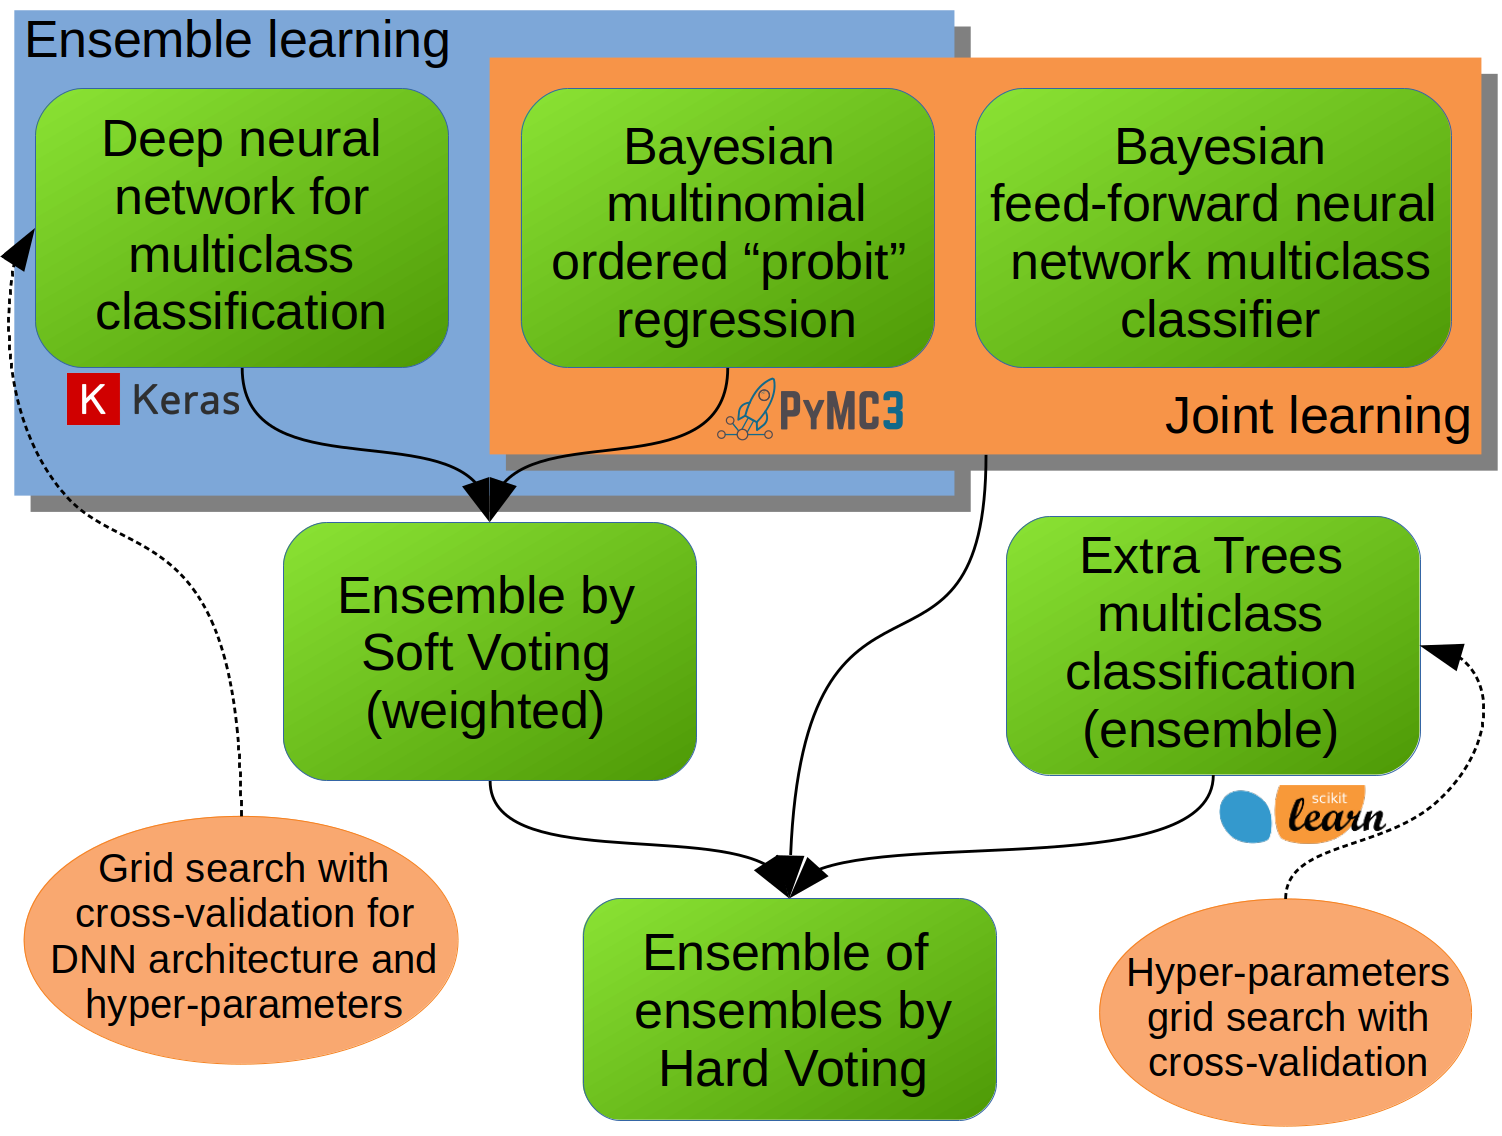

In [10]:
Image(filename="diagram.png", width=500)

### Transformer diagnostic data and health index values

Transformer diagnostic tests are described in terms of the following six parameters:
* Water (ppm)
* Acidity (mgKOH/g)
* DBV (kV)
* Dissipation factor (%)
* TDCG (ppm)
* Furan (mg/L)

In [11]:
data = pd.read_csv('Health_index.csv')
data.drop(labels=['No.'], axis=1, inplace=True)
data

,Water,Acidity,DBV,DF,TDCG,Furan,AMHA-S,AMHA,Fuzzy-S,Fuzzy,LogReg-S,LogReg,GRNN-S,GRNN
0,21.7,0.024,32.5,0.075,483,0.86,0.377,G,0.36,G,0.434,M,0.370,G
1,26.9,0.098,40.5,0.894,254,0.65,0.334,G,0.30,G,0.170,G,0.560,M
2,14.5,0.033,58.0,0.140,78,0.26,0.290,G,0.30,G,0.007,G,0.047,VG
3,21.2,0.226,48.7,0.424,215,5.53,0.700,B,0.78,B,0.826,VB,0.780,B
4,10.0,0.010,75.0,0.111,126,0.06,0.102,G,0.20,VG,0.002,G,0.030,VG
5,15.5,0.075,71.0,0.143,38,0.53,0.274,G,0.30,G,0.004,G,0.085,VG
6,16.8,0.167,70.1,0.255,149,0.78,0.316,G,0.30,G,0.023,G,0.316,G
7,15.0,0.092,67.8,0.211,28,0.69,0.290,G,0.30,G,0.006,G,0.133,VG
8,17.0,0.035,62.7,0.113,9,0.21,0.226,G,0.22,VG,0.003,G,0.040,VG
9,30.0,0.088,37.6,0.353,197,0.31,0.316,G,0.30,G,0.120,G,0.586,M


In [12]:
data['GRNN'].value_counts()/data['GRNN'].value_counts().sum()

VG    0.300000
G     0.233333
B     0.200000
M     0.166667
VB    0.100000
Name: GRNN, dtype: float64

In [13]:
# Correcting outlier with the median value of the data
median = np.percentile(data['DF'], q=50)
data.set_value(18, 'DF', median)
data.iloc[17:20]

,Water,Acidity,DBV,DF,TDCG,Furan,AMHA-S,AMHA,Fuzzy-S,Fuzzy,LogReg-S,LogReg,GRNN-S,GRNN
17,23.6,0.070,39.2,0.203,22,0.50,0.291,G,0.30,G,0.370,G,0.406,G
18,30.5,0.073,28.7,0.205,30,1.70,1.000,B,0.94,VB,0.997,VB,0.790,B
19,18.4,0.063,64.5,0.243,69,0.15,0.347,G,0.30,G,0.005,G,0.119,VG


In [14]:
# Column names
values = ['Water', 'Acidity', 'DBV', 'DF', 'TDCG', 'Furan']
values_all = ['Water', 'Acidity', 'DBV', 'DF', 'TDCG', 'Furan', 'GRNN-S']

/home/ps/anaconda2/lib/python2.7/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'color', 'label'
  s)


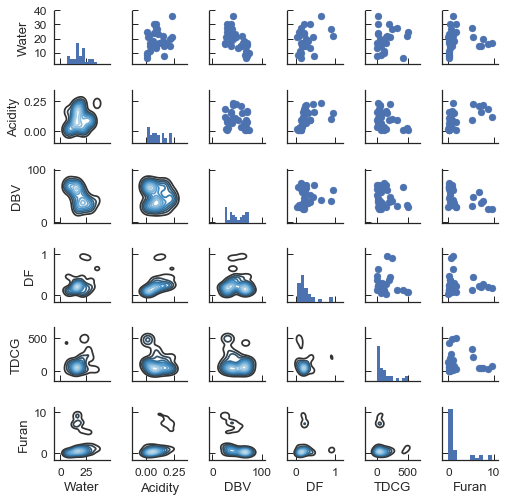

In [15]:
g = sns.PairGrid(data[values], size=1.2)  # size in inches?!
g.map_upper(plt.scatter);
g.map_lower(sns.kdeplot, cmap='Blues_d');
g.map_diag(plt.hist);

### Pearson's correlation matrix (Predictivity)

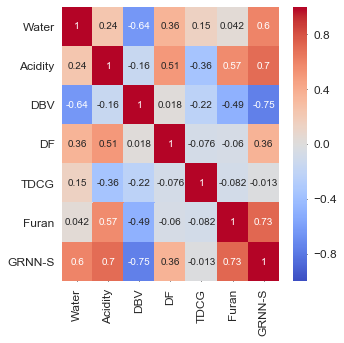

In [16]:
# Predictivity (Pearson correlation matrix)
pearson = data[values_all].corr('pearson')
# Correlation matrix as heatmap (seaborn)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(pearson, annot=True, annot_kws=dict(size=10), vmin=-1, vmax=1, cmap=plt.cm.coolwarm, ax=ax)
plt.tight_layout()
plt.show()

### Generate syntetic transformer data

In [15]:
# Generate synthetic data using the "data augmentation" technique
def trafo_measurements(df, num=100, fraction=0.1):
    data = {}
    idxmax = len(df.index)
    ranvals = np.random.randint(low=0, high=idxmax, size=num)
    for name in df.columns:
        if name == 'GRNN-S':
            data[name] = df[name].iloc[ranvals]
        else:
            sd = df[name].std()
            datavals = df[name].iloc[ranvals].values
            ransigns = np.random.choice([-1., 1.], size=num, replace=True)
            synvalues = datavals + ransigns*(sd*fraction)
            values = np.empty_like(synvalues)
            for i, val in enumerate(synvalues):
                if val > 0. or val is not np.NaN:
                    values[i] = val
                else:
                    values[i] = datavals[i]
            data[name] = np.round(values, decimals=3)
    data = pd.DataFrame(data, columns=df.columns)
    return data

Health Index values:
VB = 4 -> Very bad
 B = 3 -> Bad
 M = 2 -> Moderate
 G = 1 -> Good
VG = 0 -> Very good 

In [16]:
def from_descr_to_score(description):
    if description == 'VB':
        score = 4
    elif description == 'B':
        score = 3
    elif description == 'M':
        score = 2
    elif description == 'G':
        score = 1
    elif description == 'VG':
        score = 0
    else:
        score = None
        raise ValueError('Invalid class label {} encountered!'.format(description))
    return score

def from_score_to_descr(score):
    if score <= 0.2:
        description = 'VG'
    elif 0.2 < score <= 0.4:
        description = 'G'
    elif 0.4 < score <= 0.6:
        description = 'M'
    elif 0.6 < score <= 0.8:
        description = 'B'
    elif 0.8 < score:
        description = 'VB'
    else:
        description = None
        raise ValueError('Score value {} is outside the intended range [0-1]!'.format(score))
    return description

def from_class_to_label(cl):
    if cl == 4:
        label = 'VB'
    elif cl == 3:
        label = 'B'
    elif cl == 2:
        label = 'M'
    elif cl == 1:
        label = 'G'
    elif cl == 0:
        label = 'VG'
    else:
        label = None
        raise ValueError('Invalid class index {} encountered!'.format(cl))
    return label

In [17]:
# Generate syntetic data using "data augmentation"
syntetic = trafo_measurements(data[values_all], num=100)
syntetic['GRNN'] = syntetic['GRNN-S'].apply(from_score_to_descr)

In [18]:
data['score'] = data['GRNN'].apply(from_descr_to_score)
syntetic['score'] = syntetic['GRNN'].apply(from_descr_to_score)
syntetic.head()

,Water,Acidity,DBV,DF,TDCG,Furan,GRNN-S,GRNN,score
28,12.289,0.084,53.233,0.347,22.052,0.62,0.238,G,1
26,20.789,0.154,59.167,0.960,153.948,1.22,0.610,B,3
5,14.789,0.068,72.633,0.121,52.052,0.83,0.085,VG,0
28,12.289,0.098,53.233,0.391,22.052,0.02,0.238,G,1
28,12.289,0.084,49.967,0.391,22.052,0.02,0.238,G,1


### Data preprocessing and splitting

In [19]:
# Hand-made data split 
x_train2 = syntetic[values]
x_test2  = data[values]

In [20]:
# Standardize the data
def standardize(X_data):
    x_mean = X_data.mean(axis=0)
    x_std = X_data.std(axis=0)
    Z_data = ((X_data - x_mean)/x_std).values
    return Z_data

In [21]:
Z_data = standardize(x_train2)

In [22]:
y_train_log = syntetic['score'].values

In [23]:
n_cat = syntetic['score'].unique().size  # No. categories

## Bayesian Multinomial Ordered Probit Regression

**Note:** See the book by J. K. Kruschke, Doing Bayesian Data Analysis (2nd Edition) and the following github repository https://github.com/JWarmenhoven/DBDA-python.

**Note:** Multinomial ordered "probit" regression assumes a linear combination of the multiple metric predictors (without interaction) and an *ordered* categorical predicted variable, without imposing distance metric between the categories.

In [20]:
thresh = [k+0.5 for k in range(n_cat-1)]
thresh_obs = np.ma.asarray(thresh)
thresh_obs[1:-1] = np.ma.masked
print('thresh:\t{}'.format(thresh))
print('thresh_obs:\t{}'.format(thresh_obs))

thresh:	[0.5, 1.5, 2.5, 3.5]
thresh_obs:	[0.5 -- -- 3.5]


In [28]:
from theano.compile.ops import as_op
# Theano cannot compute a gradient for these custom functions, so it is not possible to use
# gradient based samplers in PyMC3.
@as_op(itypes=[tt.dvector, tt.dvector, tt.dscalar], otypes=[tt.dmatrix])
def outcome_probabilities(theta, mu, sigma):
    out = np.empty((mu.size, n_cat))
    n = stats.norm(loc=mu, scale=sigma)  # Normal distribution
    out[:,0] = n.cdf(theta[0])        
    out[:,1] = np.max([np.repeat(0,mu.size), n.cdf(theta[1]) - n.cdf(theta[0])], axis=0)
    out[:,2] = np.max([np.repeat(0,mu.size), n.cdf(theta[2]) - n.cdf(theta[1])], axis=0)
    out[:,3] = np.max([np.repeat(0,mu.size), n.cdf(theta[3]) - n.cdf(theta[2])], axis=0)
    out[:,4] = 1. - n.cdf(theta[3])
    return out

In [ ]:
# Version of the ordered "probit" regression that is robust against outliers
# It uses Student's t distribution instead of the Normal distribution
from theano.compile.ops import as_op
# Theano cannot compute a gradient for these custom functions, so it is not possible to use
# gradient based samplers in PyMC3.
@as_op(itypes=[tt.dvector, tt.dvector, tt.dscalar, tt.dscalar], otypes=[tt.dmatrix])
def outcome_probabilities_robust(theta, mu, sigma, nu):
    out = np.empty((mu.size, n_cat))
    n = stats.t(df=nu, loc=mu, scale=sigma)  # Student-T distribution
    out[:,0] = n.cdf(theta[0])        
    out[:,1] = np.max([np.repeat(0,mu.size), n.cdf(theta[1]) - n.cdf(theta[0])], axis=0)
    out[:,2] = np.max([np.repeat(0,mu.size), n.cdf(theta[2]) - n.cdf(theta[1])], axis=0)
    out[:,3] = np.max([np.repeat(0,mu.size), n.cdf(theta[3]) - n.cdf(theta[2])], axis=0)
    out[:,4] = 1. - n.cdf(theta[3])
    return out

In [36]:
with pm.Model() as probit:
    # Priors
    theta = pm.Normal('theta', mu=thresh, tau=np.repeat(1./2**2, len(thresh)),
                      shape=len(thresh), observed=thresh_obs)
    zbeta0 = pm.Normal('zbeta0', mu=float(n_cat)/2., tau=1./n_cat**2)
    zbeta = pm.Normal('zbeta', mu=0., tau=1./n_cat**2, shape=Z_data.shape[1])
    zsigma = pm.Uniform('zsigma', n_cat/1000., n_cat*10.)
    # Linear model
    mu = pm.Deterministic('mu', zbeta0 + pm.math.dot(zbeta, Z_data.T))
    # Link function
    pr = outcome_probabilities(theta, mu, zsigma)
    # For the *robust* version of the ordered "probit" regression
    # comment the previous line and uncomment the following lines
    ##nu = pm.Exponential('nu', lam=1./30.)
    ##pr = outcome_probabilities_robust(theta, mu, zsigma, nu)
    # Likelihood
    y = pm.Categorical('y', pr, observed=y_train_log)
    # MCMC (it is not possible to use gradient-based samplers)
    step_M = pm.Metropolis(vars=[pr, y, mu, zsigma, zbeta0, zbeta, theta])
    chain = pm.sample(draws=32000, tune=4000, step=step_M, chains=2, discard_tuned_samples=True)

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>Metropolis: [theta_missing]
>Metropolis: [zbeta]
>Metropolis: [zbeta0]
>Metropolis: [zsigma_interval__]
100%|██████████| 36000/36000 [20:20<00:00, 29.51it/s]
The number of effective samples is smaller than 10% for some parameters.


In [37]:
burnin = 2000
thin = 6
# Trace after burn-in and thinning
trace = chain[burnin::thin]

In [38]:
pm.gelman_rubin(chain, varnames=['theta_missing', 'zbeta0', 'zbeta', 'zsigma'])

{'theta_missing': array([1.00004869, 1.0000482 ]),
 'zbeta': array([1.00028025, 1.00004914, 1.00006213, 0.99999108, 0.99999495,
        0.99998857]),
 'zbeta0': 1.0000064118462242,
 'zsigma': 1.000043713513391}

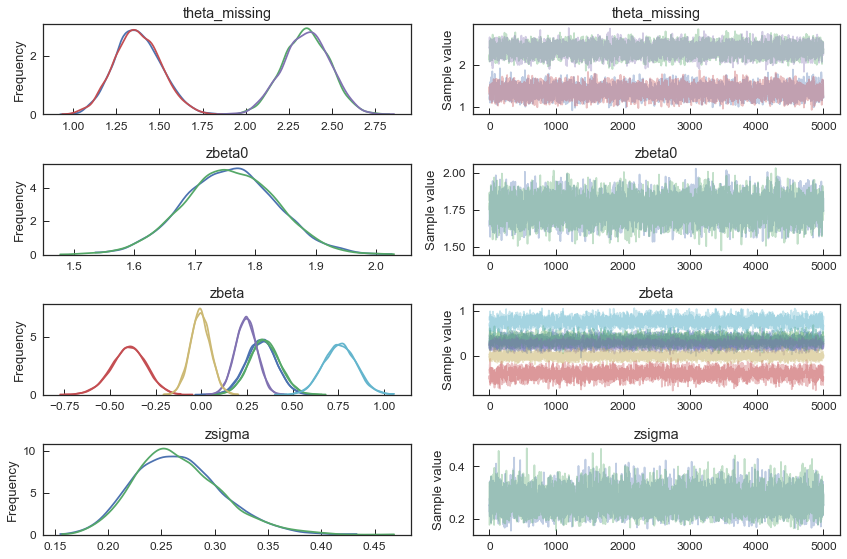

In [39]:
pm.traceplot(trace, varnames=['theta_missing', 'zbeta0', 'zbeta', 'zsigma']);

In [40]:
# Convert parameters to original scale
x_mean = x_train2.mean(axis=0).values
x_std  = x_train2.std(axis=0).values

beta = trace['zbeta']/x_std
beta0 = trace['zbeta0'] - np.sum(trace['zbeta']*x_mean/x_std, axis=1)
sigma = trace['zsigma']

# Concatenate the fixed thresholds into the estimated thresholds
n = trace['theta_missing'].shape[0]  # No. chain values
thresholds = np.c_[np.tile([0.5], (n,1)), trace['theta_missing'], np.tile([3.5], (n,1))]

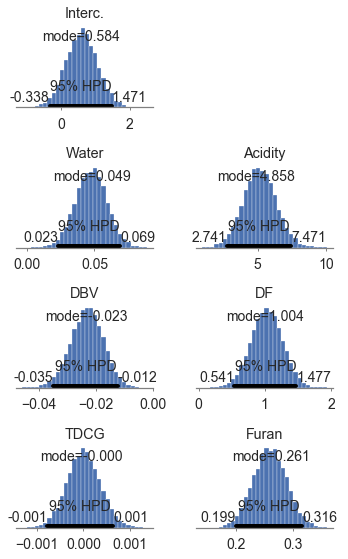

In [41]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(5,8))
ax[0,1].set_axis_off()
#ax[0,1].set_title('$\sigma$')
#pm.plot_posterior(sigma, point_estimate='mode', text_size=14, ax=ax[0,1]);
pm.plot_posterior(beta0, point_estimate='mode', text_size=14, ax=ax[0,0]);
ax[0,0].set_title('Interc.')
k = 0
for i in range(1,4):
    for j in range(2):
        k += 1
        pm.plot_posterior(beta[:,k-1], point_estimate='mode', text_size=14, ax=ax[i,j]);
        ax[i,j].set_title(values[k-1])
plt.tight_layout()
plt.show()

In [42]:
# Posterior prediction from chain 
def posterior_predictive_from_chain(n, thresholds, beta0, beta, X, mu, sigma):
    out = []
    for i in range(n):
        mu = beta0[i] + np.dot(X, beta[i,:])
        # Normal distribution
        threshCumProb = stats.norm().cdf((thresholds[i,:] - mu)/sigma[i])
        outProb = np.empty(len(threshCumProb)+1)
        for k in range(1, thresholds.shape[1]):
            outProb[k] = threshCumProb[k] - threshCumProb[k-1]
        outProb[0] = threshCumProb[0]
        outProb[thresholds.shape[1]] = 1. - threshCumProb[-1]
        out.append(outProb)
    out = np.asarray(out)
    return out

In [ ]:
# Posterior prediction from chain for the robust model
def posterior_predictive_robust_from_chain(n, thresholds, beta0, beta, X, mu, sigma, nu):
    out = []
    for i in range(n):
        mu = beta0[i] + np.dot(X, beta[i,:])
        # Student's t distribution
        threshCumProb = stats.t(df=nu[i]).cdf((thresholds[i,:] - mu)/sigma[i])
        outProb = np.empty(len(threshCumProb)+1)
        for k in range(1, thresholds.shape[1]):
            outProb[k] = threshCumProb[k] - threshCumProb[k-1]
        outProb[0] = threshCumProb[0]
        outProb[thresholds.shape[1]] = 1. - threshCumProb[-1]
        out.append(outProb)
    out = np.asarray(out)
    return out

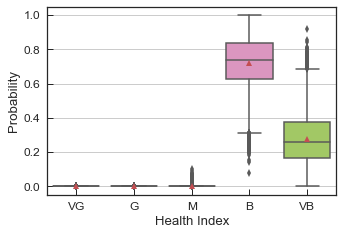

In [43]:
# Example of the posterior prediction with uncertainty of estimation
posterior_proba = posterior_predictive_from_chain(n, thresholds, beta0, beta, x_test2.values[3], mu, sigma)
posterior = pd.DataFrame(posterior_proba, columns=['VG', 'G', 'M', 'B', 'VB'])
fig, ax = plt.subplots(figsize=(5,3.5))
sns.boxplot(data=posterior, palette='Set2', linewidth=1.5, ax=ax, showmeans=True)
ax.grid(axis='y')
ax.set_xlabel('Health Index')
ax.set_ylabel('Probability')
plt.tight_layout()
plt.show()

In [44]:
# Predict class probability on test data
proba = []
for X in x_test2.values:
    out = posterior_predictive_from_chain(n, thresholds, beta0, beta, X, sigma)
    proba.append(out.mean(axis=0))
proba = np.asarray(proba)
argmaxs = proba.argmax(axis=1)
labels_pred = map(from_class_to_label, argmaxs)

In [21]:
y_t = data[['GRNN']].copy()  # instantiate dataframe for comparisons

In [46]:
#y_t['b'] = argmaxs
y_t['bayes'] = labels_pred

## Wide & Deep Bayesian multiclass classification model

The "wide part" of the model consists of the Bayesian multinomial ordered "probit" regression, which is a multiclass classification model that preserves inherent oredering between the categories, without imposing distance metric between the categories. The wide part of the model captures linear relationships between the predictors and predicted variable (including any interactions between predictors), as is the case with generalized linear models. The "deep part" of the model is a feed-forward artifical neural network with arbitrary number of hidden layers (where the number of neurons per layer can be adjusted, along with its activation functions), which means that the network can be "deep" with many densely connected layers. The last layer uses "softmax" activation, which turns the network into the multiclass classification model (without inherent odreding between the categories). The deep part of the model can capture any non-linear relationship between the predictors and predicted variable. The outputs of the wide and deep parts, which are the class outcome probabilities, are combined using the weighted avarega and fed into the likelihood function (which is the Categorical distribution). The complete model, which consists of the wide and deep parts, is jointly trained using the Markov Chain Monte Carlo (MCMC) algorithm.

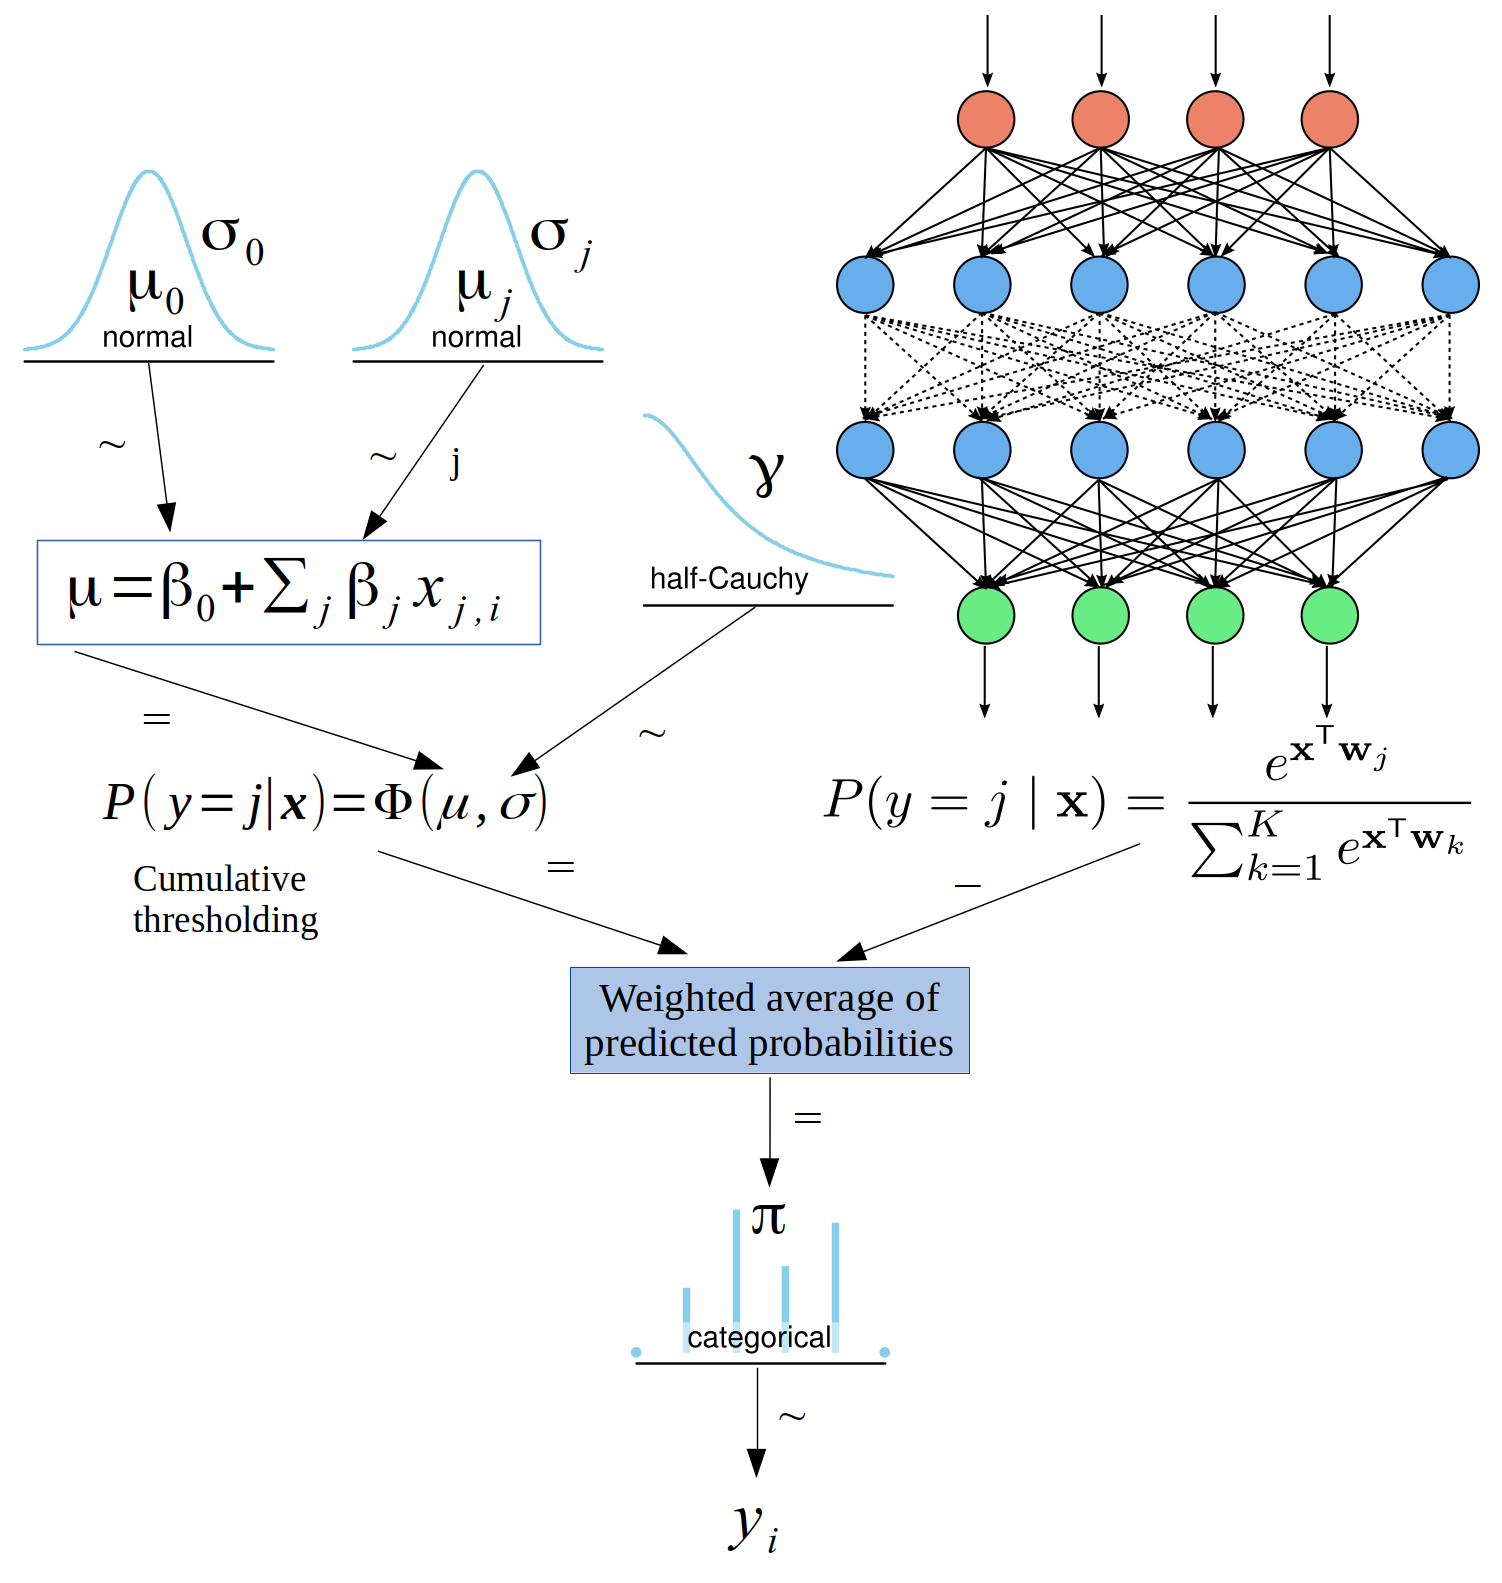

In [47]:
Image(filename="kruschke_style.png", width=500)

Wide part of the Bayesian model can be easily adapted to, and could probably benefit from, using data structure with multiple groups (e.g. distribution and transmission level transformers). This would allow for the more efficient use of unsymmetrical datasets, and would enable extending the present wide part of the model with the additional hierarchical structure that would allow informing model parameters across different groups (through the mutual higher level hyper-priors).

In [21]:
floatX = theano.config.floatX

In [22]:
# Train data (synthetic)
X_train = syntetic[values]
y_train = syntetic['score'].values
# Test data (actual)
X_test = data[values]
y_test = data['score'].values

In [23]:
# Standardize the input data for the neural network
X_train = standardize(X_train)
X_test = standardize(X_test)

**Note:** Feed-forward artifical neural network (ANN) can consist of the arbitrary number of layers (where different layers can have the same or even different number of neurons) and different activation functions. Each layer is implemented as: $\sigma(W \cdot x + b)$ where $\sigma$ is the activation function, $W$ is the weights matrix and $b$ is the bias vector. In implementing the network architecture, user needs to keep track of the dimensions of the weight matrices and bias vectors for the different layers.

In [51]:
def construct_wide_and_deep_model(ann_input, ann_output):
    """
    Network (deep part) can be extended to account for additional 
    layers (or use different activation functions on hidden layers)
    """
    # Number of neurons per layer (ANN)
    n_hidden = 10
    # Note: Network can have different number of neurons per layer,
    # in which case these would be defined here. The shapes of the 
    # tensors for different layers would need to reflect this fact,
    # which is simple matter of index house-keeping for layers. The
    # same goes for the layer random initializations.
    
    # Fixed weight for model joining
    weight = 0.5  # equal-weighted
    # Note: With defining a small "weight" value, larger emphasis 
    # is given to the deep model part (ANN), and vice-versa. As an
    # alternative, weight can be left to be estimated by the model
    # itself, as follows:
    # weight = pm.Uniform('weight', lower=0, upper=1)
    # in which case it will strongly favor the deep part (ANN) and 
    # will practically disregard the wide part.

    # Initialize random weights for layers
    init_bias = np.random.randn(n_hidden).astype(floatX)
    init_bias_out = np.random.randn(n_cat).astype(floatX)
    init_1 = np.random.randn(X_train.shape[1], n_hidden).astype(floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_out = np.random.randn(n_hidden, n_cat).astype(floatX)

    with pm.Model() as model:
        # --------------------------------------------
        # Multinomial "probit" regression (wide model)
        # --------------------------------------------
        # Priors
        theta = pm.Normal('theta', mu=thresh, tau=np.repeat(1./2**2, len(thresh)),
                          shape=len(thresh), observed=thresh_obs)
        zbeta0 = pm.Normal('zbeta0', mu=float(n_cat)/2., tau=1./n_cat**2)
        zbeta = pm.Normal('zbeta', mu=0., tau=1./n_cat**2, shape=X_train.shape[1])
        #zsigma = pm.Uniform('zsigma', n_cat/1000., n_cat*10.)
        zsigma = pm.HalfCauchy('zsigma', beta=float(n_cat)/2.)  # alternative prior
        # Linear model part
        mu = pm.Deterministic('mu', zbeta0 + pm.math.dot(ann_input, zbeta))
        # Outcome probabilities (see outside function)
        pr = outcome_probabilities(theta, mu, zsigma)
        # --------------------------------------------
        # Feed-forward neural network (deep model)
        # --------------------------------------------
        # Bias of the input layer
        b1 = pm.Normal('b1', mu=0., sd=1., shape=n_hidden, testval=init_bias)
        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_1', mu=0., sd=1., shape=(X_train.shape[1], n_hidden), 
                                 testval=init_1)
        # Bias of the hidden layer
        b2 = pm.Normal('b2', mu=0., sd=1., shape=n_hidden, testval=init_bias)
        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_12', mu=0., sd=1., shape=(n_hidden, n_hidden), 
                                testval=init_2)
        # *** Add additional hidden layers here ***
        # Bias of the output layer
        b3 = pm.Normal('b3', mu=0., sd=1., shape=n_cat, testval=init_bias_out)
        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2', mu=0., sd=1., shape=(n_hidden, n_cat), 
                                  testval=init_out)
        # Build feed-forward neural network from layers (additional layers can be added)
        z1 = pm.math.dot(ann_input, weights_in_1) + b1
        act_1 = pm.math.tanh(z1)  # or tt.tanh(z1) -> "tanh" activation function
        # Other activation functions could be used, such as:
        #act_1 = tt.nnet.relu(z1)  # "relu" activation function
        #act_1 = tt.nnet.sigmoid(z1)  # "sigmoid" activation func.
        z2 = pm.math.dot(act_1, weights_1_2) + b2
        act_2 = pm.math.tanh(z2)
        # *** Process additional hidden layers here ***
        z3 = pm.math.dot(act_2, weights_2_out) + b3
        # Softmax activation for outcome probabilities
        act_out = tt.nnet.softmax(z3)
        # --------------------------------------------
        # Joining wide & deep model parts 
        # --------------------------------------------
        # Weighted average of probabilities from wide & deep parts
        proba = pm.Deterministic('proba', pr*weight + act_out*(1. - weight))

        # Multiclass classification -> Categorical likelihood
        out = pm.Categorical('out', p=proba, observed=ann_output)
    return model

In [52]:
ann_input = theano.shared(X_train)
ann_output = theano.shared(y_train)
model = construct_wide_and_deep_model(ann_input, ann_output)

In [53]:
# MCMC sampling (it is not possible to use gradient-based samplers)
with model:
    step_M = pm.Metropolis()
    chain = pm.sample(draws=32000, tune=6000, step=step_M, chains=2, discard_tuned_samples=True)

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>Metropolis: [w_2_out]
>Metropolis: [b3]
>Metropolis: [w_1_2]
>Metropolis: [b2]
>Metropolis: [w_in_1]
>Metropolis: [b1]
>Metropolis: [zsigma_log__]
>Metropolis: [zbeta]
>Metropolis: [zbeta0]
>Metropolis: [theta_missing]
100%|██████████| 38000/38000 [1:48:13<00:00,  5.85it/s]
The number of effective samples is smaller than 10% for some parameters.


In [55]:
# Trace after burn-in and thinning
model_trace = chain[burnin::thin]

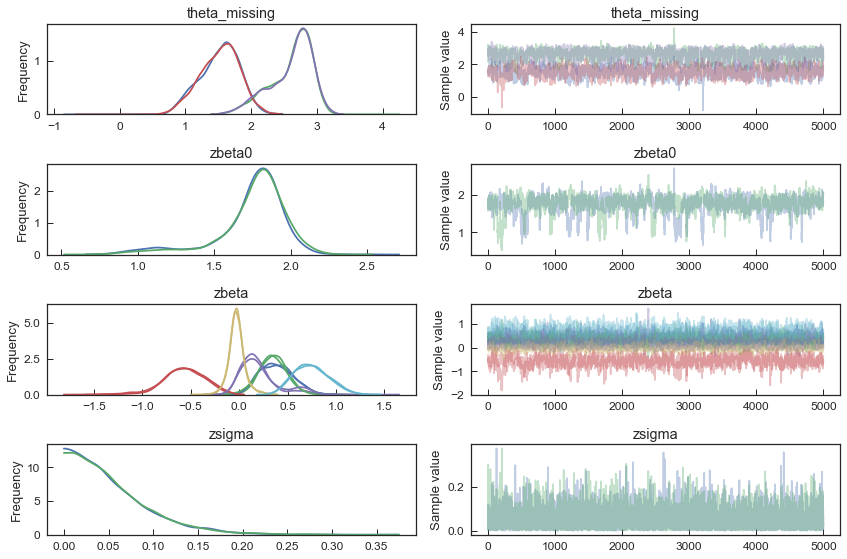

In [56]:
pm.traceplot(model_trace, varnames=['theta_missing', 'zbeta0', 'zbeta', 'zsigma']);

In [57]:
# Predict class probability on test data
ann_input.set_value(X_test)
ann_output.set_value(y_test)
with model:
    model_ppc = pm.sample_ppc(model_trace, samples=1000)

100%|██████████| 1000/1000 [00:01<00:00, 552.35it/s]


In [58]:
y_t['m'] = np.median(model_ppc['out'], axis=0)
y_t['model'] = y_t['m'].apply(from_class_to_label)
del y_t['m']

In [59]:
y_t

,GRNN,bayes,model
0,G,G,M
1,M,B,M
2,VG,VG,VG
3,B,B,B
4,VG,VG,VG
5,VG,VG,VG
6,G,G,G
7,VG,VG,G
8,VG,VG,VG
9,M,M,M


## Keras deep neural network

In [60]:
# Encode 'targets' to categorical variables
y_train_nn = keras.utils.np_utils.to_categorical(y_train)
y_test_nn = keras.utils.np_utils.to_categorical(y_test)

In [61]:
BATCH = 32     # 'batch_size' argument
EPOCHS = 200   # 'epochs' argument

#### Keras DNN with grid search and cross-validation for network architecture and hyper-parameters optimisation

In [62]:
def keras_dnn(hidden_layers, number_neurons, activation, dropout):
    # Deep feed-forward artificial neural network
    model = keras.models.Sequential()
    # Input layer
    model.add(keras.layers.Dense(units=64, activation='relu', input_dim=X_train.shape[1]))
    # Hidden layers architecture
    for layer in range(hidden_layers):
        # Add hidden layer (densely connected)
        model.add(keras.layers.Dense(units=number_neurons, activation=activation))
        # Add regularizing layer
        model.add(keras.layers.Dropout(dropout))
    # Output layer
    model.add(keras.layers.Dense(units=5, activation='softmax'))  # five classes
    # Optimizer
    adam = keras.optimizers.Adam()
    # Compile network
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

In [63]:
# Instantiate Keras Classifier scikit-learn API (wrapped keras model)
network = KerasClassifier(build_fn=keras_dnn, epochs=100, batch_size=BATCH)
# Instantiate GridSearchCV
dnn = GridSearchCV(network, param_grid={'hidden_layers':[3, 4],
                                        'number_neurons':[64, 32],
                                        'activation':['relu', 'tanh'], 
                                        'dropout':[0.5]},
                   scoring='neg_log_loss', cv=3, n_jobs=1, verbose=0)
dnn.fit(X_train, y_train_nn, verbose=0)

32/67 [=============>................] - ETA: 0s

GridSearchCV(cv=3, error_score='raise',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7ffb54bc4690>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'number_neurons': [64, 32], 'activation': ['relu', 'tanh'], 'hidden_layers': [3, 4], 'dropout': [0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [64]:
print('The parameters of the best DNN are: ')
print(dnn.best_params_)

The parameters of the best DNN are: 
{'number_neurons': 64, 'activation': 'tanh', 'hidden_layers': 3, 'dropout': 0.5}


In [65]:
# Use the best DNN for prediction
best_dnn = dnn.best_estimator_.model  # unwrapped keras model
y_test_eval_proba = best_dnn.predict_proba(X_test)

30/30 [==============================] - 0s


In [66]:
# Network architecture
best_dnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_133 (Dense)            (None, 64)                448       
_________________________________________________________________
dense_134 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_85 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_135 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_86 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_136 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_87 (Dropout)         (None, 64)                0         
__________

In [67]:
# Score metrics (evaluate best model on test data)
score_best = best_dnn.evaluate(X_test, y_test_nn, batch_size=BATCH, verbose=0)
print('Log-loss: {:g}, Accuracy: {:.2f} %'.format(score_best[0], score_best[1]*100))

Log-loss: 0.396078, Accuracy: 80.00 %


In [68]:
y_t['b'] = y_test_eval_proba.argmax(axis=1)
y_t['best_dnn'] = y_t['b'].apply(from_class_to_label)
del y_t['b']

#### Keras DNN with fixed number of layers and hyper-parameters (classic approach)

In [69]:
# Keras: Feed-forward neural network for multi-class classification
model = keras.models.Sequential()
# Input layer
model.add(keras.layers.Dense(units=64, activation='relu', input_dim=X_train.shape[1]))
model.add(keras.layers.Dropout(0.5))  # regularization layer
# hidden layer
model.add(keras.layers.Dense(units=64, activation='relu'))
model.add(keras.layers.Dropout(0.5))
# hidden layer
model.add(keras.layers.Dense(units=64, activation='relu'))
model.add(keras.layers.Dropout(0.5))
# hidden layer
model.add(keras.layers.Dense(units=64, activation='tanh'))
model.add(keras.layers.Dropout(0.5))
# Output layer
model.add(keras.layers.Dense(units=5, activation='softmax'))
# Optimizer
adam = keras.optimizers.Adam()
# Compile network
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [70]:
# Fit model on train data
history = model.fit(X_train, y_train_nn, epochs=EPOCHS, batch_size=BATCH, 
                    validation_data=(X_test, y_test_nn), shuffle=True, verbose=0)
# Score metrics (evaluate model on test data)
score = model.evaluate(X_test, y_test_nn, batch_size=BATCH, verbose=0)
print('Log-loss: {:g}, Accuracy: {:.2f} %'.format(score[0], score[1]*100))

Log-loss: 0.329999, Accuracy: 83.33 %


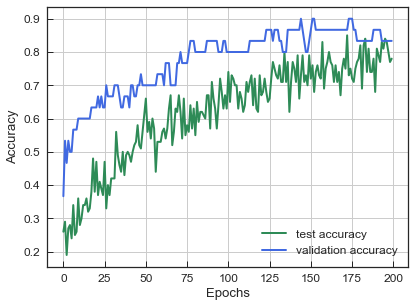

In [71]:
hist = history.history
acc = hist['acc']
acc_val = hist['val_acc']
fig, ax = plt.subplots(figsize=(6,4.5))
ax.plot(acc, ls='-', lw=2, c='seagreen', label='test accuracy')
ax.plot(acc_val, ls='-', lw=2, c='royalblue', label='validation accuracy')
ax.grid()
ax.legend(loc='best', fontsize=12)
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
plt.tight_layout()
plt.show()

In [72]:
# Predict class probability on test data
y_pred_proba_nn = model.predict_proba(X_test, batch_size=BATCH, verbose=0)
y_t['k'] = y_pred_proba_nn.argmax(axis=1)
y_t['keras'] = y_t['k'].apply(from_class_to_label)
del y_t['k']

## Ensemble models using "soft voting"

In [73]:
# Models: Bayes & Keras
weights = np.asarray([1., 1.])  # Bayes:Keras weights
proba_weighted = np.empty_like(proba)
for k in range(proba.shape[0]):
    #predictions = np.vstack((proba[k], y_pred_proba_nn[k])).T  # fixed DNN
    predictions = np.vstack((proba[k], y_test_eval_proba[k])).T  # optimised DNN
    proba_weighted[k] = np.dot(predictions, weights)/weights.sum()

In [74]:
y_t['e'] = proba_weighted.argmax(axis=1)
y_t['soft_vote'] = y_t['e'].apply(from_class_to_label)
del y_t['e']

## ExtraTreesClassifier

In [75]:
# ExtraTreesClassifier (ensemble learner) with grid search 
# and cross-validation for hyper-parameters optimisation
parameters = {'n_estimators':[5, 10, 15, 20], 
              'criterion':['gini', 'entropy'], 
              'max_depth':[2, 5, None]}
trees = GridSearchCV(estimator=ExtraTreesClassifier(), param_grid=parameters, 
                     cv=3, scoring='neg_log_loss', refit=True, n_jobs=-1) 
trees.fit(X_train, y_train)
y_trees = trees.predict_proba(X_test)

In [76]:
# Best model parameters
trees.best_params_

{'criterion': 'entropy', 'max_depth': None, 'n_estimators': 20}

In [77]:
y_t['t'] = y_trees.argmax(axis=1)
y_t['trees'] = y_t['t'].apply(from_class_to_label)
del y_t['t']

## Ensemble models using "hard voting"

In [78]:
# Models: Wide&Deep & Ensemble & ExtraTrees
hard_vote = []
wide_deep = np.median(model_ppc['out'], axis=0)
for k in range(proba.shape[0]):
    hard_vote.append((wide_deep[k].argmax(), proba_weighted[k].argmax(), y_trees[k].argmax()))
counts = [np.bincount(x).argmax() for x in hard_vote]
y_t['h'] = counts
y_t['hard_vote'] = y_t['h'].apply(from_class_to_label)
del y_t['h']

#### Predictions using individual classifiers and ensembles

In [79]:
y_t

,GRNN,bayes,model,best_dnn,keras,soft_vote,trees,hard_vote
0,G,G,M,M,M,G,G,G
1,M,B,M,M,M,M,M,M
2,VG,VG,VG,VG,VG,VG,VG,VG
3,B,B,B,B,B,B,B,B
4,VG,VG,VG,VG,VG,VG,VG,VG
5,VG,VG,VG,VG,VG,VG,VG,VG
6,G,G,G,G,G,G,G,G
7,VG,VG,G,VG,VG,VG,VG,VG
8,VG,VG,VG,VG,VG,VG,VG,VG
9,M,M,M,M,M,M,M,M


**Note:** Model accuracy depends on the random synthetic dataset used during the learning phase, which has been generated from the original dataset (used for testing) by means of the simple "data augmentation" technique. Possibility for overfitting and underfitting should be further examined, preferably with a larger dataset.

## Supplementary information and models

#### Feature importance analysis with GradientBoosting classifier

In [31]:
# Train & evaluate model performance
def train_and_evaluate(model, X, y, ns=3):
    # k-fold cross validation iterator 
    cv = KFold(n_splits=ns, shuffle=True)
    scores = cross_val_score(model, X, y, cv=cv)
    print('Score using {:d}-fold CV: {:g} +/- {:g}'.format(ns, np.mean(scores), np.std(scores)))

In [37]:
# Data standardization
X_stand = preprocessing.scale(x_train2)
# Gradient Boosting Classifier
clf_gb = GradientBoostingClassifier()
train_and_evaluate(clf_gb, X_stand, y_train_log)
clf_gb.fit(X_stand, y_train_log)

Score using 3-fold CV: 0.860071 +/- 0.0374544


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

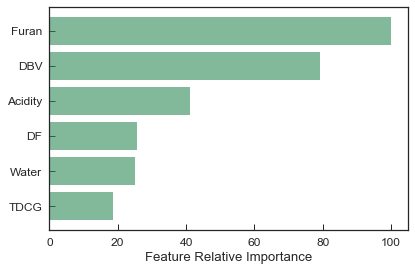

In [38]:
# Feature importance
feature_importance = clf_gb.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
# Plot relative feature importance
fig, ax = plt.subplots(figsize=(6,4))
ax.barh(pos, feature_importance[sorted_idx], align='center', color='seagreen', alpha=0.6)
plt.yticks(pos, data.columns[sorted_idx])
ax.set_xlabel('Feature Relative Importance')
plt.tight_layout()
plt.show()

#### Bayesian multinomial logistic regression (nominal predicted variable)

In [41]:
with pm.Model() as model:
    # priors for categories 1-4, excluding reference category 0 which is set to zero below
    zbeta0_temp = pm.Normal('zbeta0_temp', mu=0., tau=1./20**2, shape=4)
    # using all (six) of the predictor variables
    zbetak_temp = pm.Normal('zbetak_temp', mu=0., tau=1./20**2, shape=(6, 4))
    # add prior values zero (intercept, predictors) for reference category 0
    zbeta0 = pm.Deterministic('zbeta0', tt.concatenate([[0], zbeta0_temp]))
    zbetak = pm.Deterministic('zbetak', tt.concatenate([tt.zeros((6, 1)), zbetak_temp], axis=1))
    # Multiple regression 
    mu = pm.Deterministic('mu', zbeta0 + pm.math.dot(Z_data, zbetak))
    # Theano softmax function (logistic)
    p = pm.Deterministic('p', tt.nnet.softmax(mu))
    # Likelihood
    y = pm.Categorical('y_hat', p=p, observed=y_train_log)
    # MCMC
    chain = pm.sample(draws=22000, tune=4000, chains=2, discard_tuned_samples=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [zbetak_temp, zbeta0_temp]
100%|██████████| 26000/26000 [11:22<00:00, 38.07it/s]


In [42]:
burnin = 2000
thin = 4
trace = chain[burnin::thin]

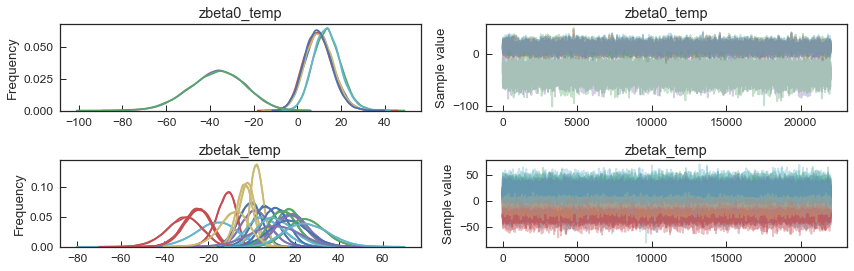

In [43]:
pm.traceplot(chain, varnames=['zbeta0_temp', 'zbetak_temp']);

In [44]:
# Transform model parameters back to the original scale
zbeta0 = trace['zbeta0']
zbetak = trace['zbetak']
x_mean = x_train2.mean(axis=0)
x_std  = x_train2.std(axis=0)
beta0 = zbeta0 - np.sum(zbetak*(np.tile(x_mean, (n_cat,1))/np.tile(x_std, (n_cat,1))).T, axis=1)
betak = np.divide(zbetak, np.tile(x_std, (n_cat,1)).T)
estimates = np.insert(betak, 0, beta0, axis=1)

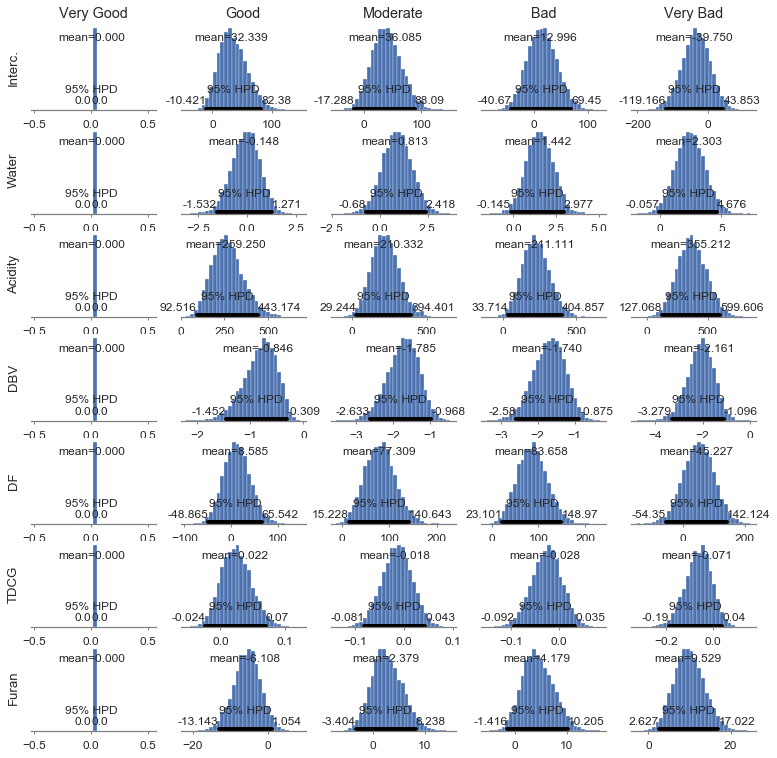

In [51]:
beta_values = ['Interc.'] + values
# Plot the posterior distributions
fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(13,13))
for (r,c), ax in np.ndenumerate(axes):
    pm.plot_posterior(estimates[:,r,c], point_estimate='mean', text_size=12, ax=ax);
# Setting labels for the outcomes
for ax, title in zip(axes[0,:], ['Very Good', 'Good', 'Moderate', 'Bad', 'Very Bad']):
    ax.set_title(title)
# Setting labels for the predictors
for ax, title in zip(axes[:,0], beta_values):
    ax.set_ylabel(title);

In [52]:
# Predictions from softmax regression (using values from the MCMC chain)
def predict_nominal_from_chain(beta_0, beta_k, X):
    Y_pred = np.empty_like(beta_0)
    p = np.empty_like(beta_0)
    # For each value in chain
    for i in range(beta_0.shape[0]):
        Y_pred[i] = beta_0[i] + np.dot(X, beta_k[i])
        for j in range(beta_0.shape[1]):
            p[i,j] = np.exp(Y_pred[i,j])/np.sum(np.exp(Y_pred[i]))
    mean_proba = p.mean(axis=0)
    return mean_proba

In [ ]:
# Predict class on new data
klasa = []
for k in range(x_test2.shape[0]):
    # Class probabilities
    proba = predict_nominal_from_chain(beta0, betak, x_test2.iloc[k].values)
    # Class labels
    klasa.append(from_class_to_label(np.argmax(proba)))
y_t['LogReg'] = np.asarray(klasa)

#### Alternative implementation of the Bayesian multinomial ordered regression (ordinal predicted variable)

**Note:** See the book by R. McElreath, Statistical Rethinking: A Bayesian course with examples in R and Stan, CRC Press and a following link: https://github.com/aloctavodia/Statistical-Rethinking-with-Python-and-PyMC3

In [24]:
class Ordered(pm.distributions.transforms.ElemwiseTransform):
    name = "ordered"

    def forward(self, x):
        out = tt.zeros(x.shape)
        out = tt.inc_subtensor(out[0], x[0])
        out = tt.inc_subtensor(out[1:], tt.log(x[1:] - x[:-1]))
        return out
    
    def forward_val(self, x, point=None):
        x, = pm.distributions.distribution.draw_values([x], point=point)
        return self.forward(x)

    def backward(self, y):
        out = tt.zeros(y.shape)
        out = tt.inc_subtensor(out[0], y[0])
        out = tt.inc_subtensor(out[1:], tt.exp(y[1:]))
        return tt.cumsum(out)

    def jacobian_det(self, y):
        return tt.sum(y[1:])

In [25]:
class OrderedLogistic(pm.distributions.Categorical):
    """
    Ordered Logistic Categorical log-likelihood.
    Useful for regression on ordinal data values whose values range
    from 1 to K as a function of some predictor, :math:`\eta`. The
    cutpoints, :math:`c`, separate which ranges of :math:`\eta` are
    mapped to which of the K observed dependent variables.  The number
    of cutpoints is K - 1.  It is recommended that the cutpoints are
    constrained to be ordered.
    
    Parameters
    ----------
    eta : float
        The predictor.
    cutpoints : array
        The length K - 1 array of cutpoints which break :math:`\eta` into
        ranges.  Do not explicitly set the first and last elements of
        :math:`cutpoints` to negative and positive infinity.
    """

    def __init__(self, eta, cutpoints, *args, **kwargs):
        self.eta = tt.as_tensor_variable(eta)
        self.cutpoints = tt.as_tensor_variable(cutpoints)
        # Sigmoid inverse link function
        pa = pm.math.sigmoid(tt.shape_padleft(self.cutpoints) - tt.shape_padright(self.eta))
        p_cum = tt.concatenate([tt.zeros_like(tt.shape_padright(pa[:, 0])),
                pa, tt.ones_like(tt.shape_padright(pa[:, 0]))], axis=1)
        proba = p_cum[:, 1:] - p_cum[:, :-1]
        super(OrderedLogistic, self).__init__(p=proba, *args, **kwargs)

    def _repr_latex_(self, name=None, dist=None):
        if dist is None:
            dist = self
        name_eta = get_variable_name(dist.eta)
        name_cutpoints = get_variable_name(dist.cutpoints)
        return (r'${} \sim \text{{OrderedLogistic}}'
                r'(\mathit{{eta}}={}, \mathit{{cutpoints}}={}$'
                .format(name, name_eta, name_cutpoints))

In [26]:
model_input = theano.shared(X_train)
model_output = theano.shared(y_train)

In [40]:
with pm.Model() as ordered:
    # Priors
    theta = pm.Normal('theta', mu=thresh, tau=np.repeat(1./2**2, len(thresh)), 
                      shape=len(thresh), transform=Ordered())
    zbeta = pm.Normal('zbeta', mu=0., tau=1./n_cat**2, shape=6)  # all six predictors
    # Linear model
    mu = pm.Deterministic('mu', pm.math.dot(model_input, zbeta))
    # Likelihood
    y = OrderedLogistic('y', cutpoints=theta, eta=mu, observed=model_output)
    # MCMC
    chain = pm.sample(draws=32000, tune=6000, chains=2, nuts_kwargs={'target_accept':0.95}, 
                      discard_tuned_samples=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [zbeta, theta_ordered__]
100%|██████████| 38000/38000 [03:32<00:00, 178.98it/s]


In [41]:
burnin = 2000
thin = 6
# Trace after burn-in and thinning
trace = chain[burnin::thin]

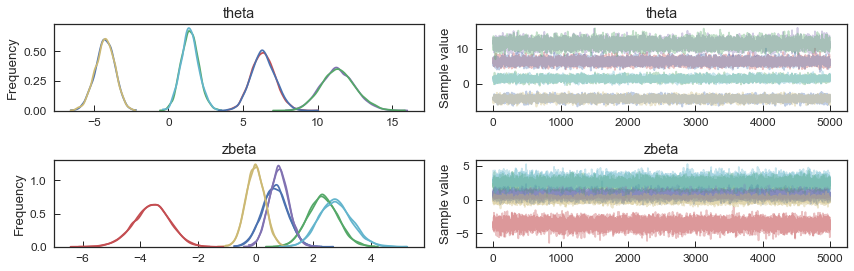

In [42]:
pm.traceplot(trace, varnames=['theta', 'zbeta']);

In [43]:
# Predict class probability on test data
model_input.set_value(X_test)
model_output.set_value(y_test)
with ordered:
    model_ppc = pm.sample_ppc(trace, samples=1000)

100%|██████████| 1000/1000 [00:00<00:00, 1193.22it/s]


In [44]:
# Median point estimate for class labels
y_t['b2'] = np.median(model_ppc['y'], axis=0)
y_t['Bayes2'] = y_t['b2'].apply(from_class_to_label)
del y_t['b2']

In [58]:
import sys, IPython, platform, sklearn
print("Notebook createad on {:s} computer running {:s} and using:\
      \nPython {:s}\nIPython {:s}\nPyMC3 {:s}\nScikit-learn {:s}\nPandas {:s}\nNumpy {:s}\n"\
      .format(platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], 
              IPython.__version__, pm.__version__, sklearn.__version__, 
              pd.__version__, np.__version__))

Notebook createad on x86_64 computer running debian buster/sid and using:      
Python 2.7.1
IPython 5.4.1
PyMC3 3.3
Scikit-learn 0.19.1
Pandas 0.22.0
Numpy 1.14.2

